In [ ]:
from langchain.vectorstores import Chroma 
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.output_parsers import StrOutputParser
from pathlib import Path
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import TypedDict, List
from langchain import hub
from langchain.schema import Document
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import START, END, StateGraph
import os

In [ ]:
# Inilization of variables

embedding_model = "BAAI/bge-small-en-v1.5"

llm = ChatGroq(model="Llama-3.3-70b-Versatile", 
               api_key="xxx")

search = DuckDuckGoSearchRun()

DATA_PATH = "dataset/crimial_lab.pdf"
VECTOR_STORE_DIR = "chroma_db"
chunk_size=750
chunk_overlap=200

In [ ]:
# It will read all the pdf from the directory and return the retrived documents
def pdf_loader(data_path):
    loader = PyPDFLoader(data_path)
    pages = loader.load()
    print('Data is Loaded')
    return pages


# Split the text into chunks and save the vector store 
def create_new_vector_store(vectore_store_path, chunk_size, chunk_overlap):

    documents = pdf_loader(DATA_PATH)

    text_splitter = CharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    docs = text_splitter.split_documents(documents)

    embeddings = HuggingFaceEmbeddings(model_name=embedding_model)
    
    vector_store = Chroma(
        collection_name="rag-chroma",
        embedding_function=embeddings,
        persist_directory=vectore_store_path  
    )

    vector_store.add_documents(docs)
    print('Chroma date is saved')
    
    return vector_store

# read the vector store from directory and return it
def load_existing_vector_store(VECTOR_STORE_DIR):
    embeddings = HuggingFaceEmbeddings(model_name=embedding_model)

    vector_store = Chroma(
        collection_name="rag-chroma",
        embedding_function=embeddings,
        persist_directory=VECTOR_STORE_DIR
    )

    print('Chroma date is loaded')
    return vector_store

In [ ]:
# Inilize AgentState

class AgentState(TypedDict):
    question: str
    documents: List[str]
    web_search: str
    generation: str

In [ ]:
# It will load the vector_store and return the similar documents
def retrive_document(state):

    print('-> Retrive Document ->')

    query = state['question']
    
    if Path(VECTOR_STORE_DIR).exists():
        # Try to load existing vector store
        vector_store = load_existing_vector_store(VECTOR_STORE_DIR)
    else:
        # Create new vector store if directory doesn't exist
        vector_store = create_new_vector_store(VECTOR_STORE_DIR, chunk_size, chunk_overlap)

    results = vector_store.similarity_search(
        query=query, 
        k=2
    )

    return {'documents': results}

In [ ]:
# Inilization thee Pydentic class it is used to get output structure of llm
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

llm_with_grade = llm.with_structured_output(GradeDocuments)

# Grading document relevent or not
def grade_document(state):

    print('-> grade Document ->')

    documents = state['documents']
    question = state['question']    
    
    system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

    chat_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Retrived document: \n\n {document} \n\n User question: \n\n{question}")
        ]
    )

    chain = chat_prompt | llm_with_grade

    web_search = "no"

    filtered_docs = []

    for d in documents:
        score = chain.invoke({"document": d.page_content, "question": question})

        grade = score.binary_score

        if grade == "yes":
            filtered_docs.append(d)
        else:
            web_search = "yes"
            continue
    
    return {"documents": filtered_docs, "web_search": web_search, "question": question} 


In [ ]:
# based on either the document is relevent or not it will route the flow
def router(state):

    print("-> Router ->")

    state["question"]
    state["documents"]

    web_search = state["web_search"]

    if web_search == "yes":
        return "transform"
    else:
        return "generate"

In [ ]:
# it will take the question and rewrite it so DuckDuckGo can search the ans in web
def transform_query(state):

    print('-> Transform Query ->')

    question = state["question"]
    
    documents = state["documents"]

    system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Make sure to only write the optimized qestion only just write in one sentence"""
     
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )

    question_rewriter = re_write_prompt | llm | StrOutputParser()

    better_question = question_rewriter.invoke({"question": question})

    return {"documents": documents, "question": better_question}

In [ ]:
# Doing the web search and return the ans
def web_search(state):

    print("-> Web Search ->")
    
    question = state["question"]
    
    documents = state["documents"]

    docs = search.invoke(question)
    
    web_results = Document(page_content=docs)
    
    documents.append(web_results)

    return {"documents": documents, "question": question}

In [ ]:
# the document are given to the llm and it will return humanize output
def generate_output(state):

    print('-> Generate Output ->')

    documents = state['documents']
    question = state['question']  
    
    prompt = hub.pull("rlm/rag-prompt")

    chain = prompt | llm | StrOutputParser()

    generated_output = chain.invoke({"context": documents, "question": question})

    return {"generation": generated_output}

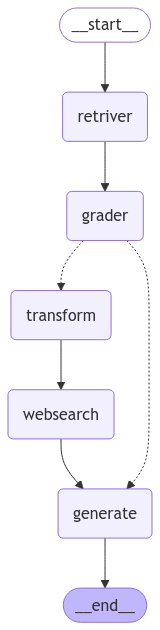

In [ ]:
# Inilization of the graph 
worflow = StateGraph(AgentState)

worflow.add_node("retriver", retrive_document)
worflow.add_node("grader", grade_document)
worflow.add_node("transform", transform_query)
worflow.add_node("websearch", web_search)
worflow.add_node("generate", generate_output)

worflow.add_edge(START, "retriver")
worflow.add_edge("retriver", "grader")
worflow.add_conditional_edges(
    "grader",
    router,
    {
        "transform": "transform",
        "generate": "generate"
    }
)
worflow.add_edge("transform", "websearch")
worflow.add_edge("websearch", "generate")
worflow.add_edge("generate", END)

app = worflow.compile()
app

In [ ]:
# Inference testing where it use default RAG

app.invoke({"question": "in case of caught in killing how many years of jail"})

-> Retrive Document ->
Chroma date is loaded
-> grade Document ->
-> Router ->
-> Generate Output ->


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


{'question': 'in case of caught in killing how many years of jail',
 'documents': [Document(metadata={'author': 'Administrator', 'creationdate': '2006-08-30T15:58:35+00:00', 'creator': 'PScript5.dll Version 5.2.2', 'keywords': '1501764525-THE-INDIAN-PENAL-CODE-1860', 'moddate': '2018-06-04T13:24:44+05:30', 'page': 47, 'page_label': '48', 'producer': 'GPL Ghostscript 8.15; modified using iText® 7.0.4 ©2000-2017 iText Group NV (AGPL-version)', 'source': 'dataset/crimial_lab.pdf', 'title': '1501764525-THE-INDIAN-PENAL-CODE-1860', 'total_pages': 227}, page_content="imprisonment of either description for a term which may extend to \nfourteen years, and shall also be liable to fine. \nIllustration \nA instigates B to murder Z. The offence is not committed. If B \nhad murdered Z, he would have been subject to the punishment of death \nor 1*[imprisonment for life]. Therefore A is liable to imprisonment \nfor a term which may extend to seven years and also to a fine; and, if \nany hurt be done 

In [ ]:
# Inference testing where it search for the answer

app.invoke({"question": "what is vector store"})

-> Retrive Document ->
Chroma date is loaded
-> grade Document ->
-> Router ->
-> Transform Query ->
-> Web Search ->
-> Generate Output ->


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


{'question': 'What is a vector store and how does it work in databases and artificial intelligence applications.',
 'documents': [Document(metadata={}, page_content="Vector databases store, search, and retrieve embeddings, also called vector embeddings. An embedding is a numerical representation of data, such as text, images, or videos. To create these vectors, unstructured data must undergo an embedding process, where it is converted into lower-dimensional vector data using machine learning models. Vector databases are growing in popularity because they deliver the speed and performance needed to drive generative artificial intelligence (AI) use cases and applications. According to Gartner®, by 2026, more than 30% of enterprises will have adopted vector databases to build their foundation models with relevant business data. 1 Vector databases are a specialized type of database designed to efficiently store, manage, and query high-dimensional vector data. These databases have become in